TensorFlow Version: 2.19.0

--- Loading Data ---
Data Cube Shape: (145, 145, 200)
Ground Truth Shape: (145, 145)

--- Performing PCA ---
PCA completed. New data shape: (145, 145, 3)

--- Creating Image Patches ---
Created 10249 image patches of size 9x9

--- Splitting Data ---
Training samples: 8199
Testing samples: 2050

--- Building and Training CNN ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 9, 9, 8)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 4, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,288 (8.94 KB)

 Trainable params: 2,288 (8.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.2555 - loss: 1501.4474 - val_accuracy: 0.4376 - val_loss: 292.2411
Epoch 2/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4474 - loss: 249.8879 - val_accuracy: 0.4551 - val_loss: 168.7943
Epoch 3/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4993 - loss: 142.4164 - val_accuracy: 0.5400 - val_loss: 103.9949
Epoch 4/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5453 - loss: 94.3323 - val_accuracy: 0.5283 - val_loss: 79.5121
Epoch 5/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5650 - loss: 66.2352 - val_accuracy: 0.5659 - val_loss: 59.5355
Epoch 6/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5744 - loss: 55.1801 - val_accuracy: 0.5912 - val_loss: 49.3037
Epoch 7/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5784 - loss: 44.8346 - val_accuracy: 0.5624 - val_loss: 45.7983
Epoch 8/20
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5979 - loss: 38.

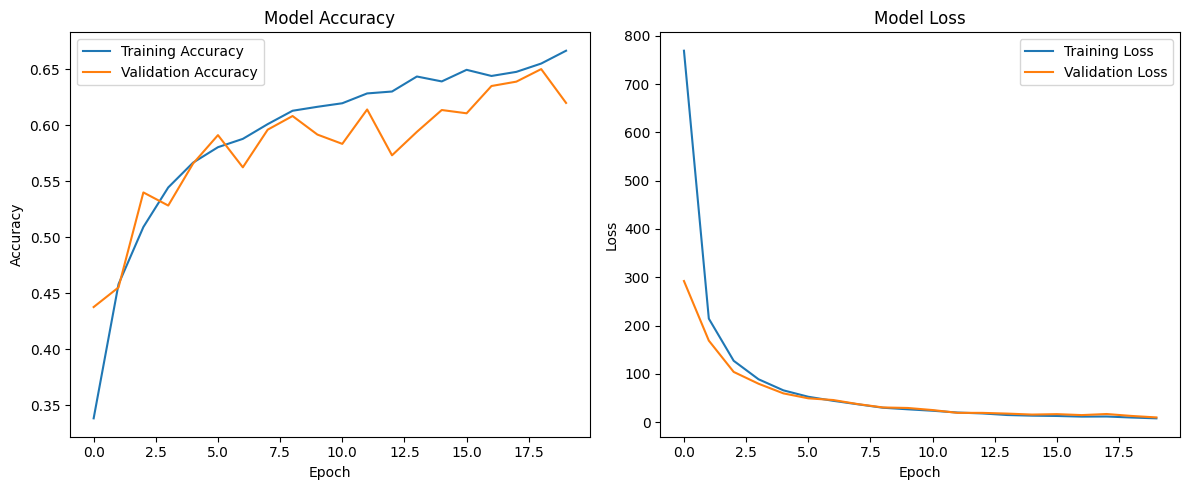

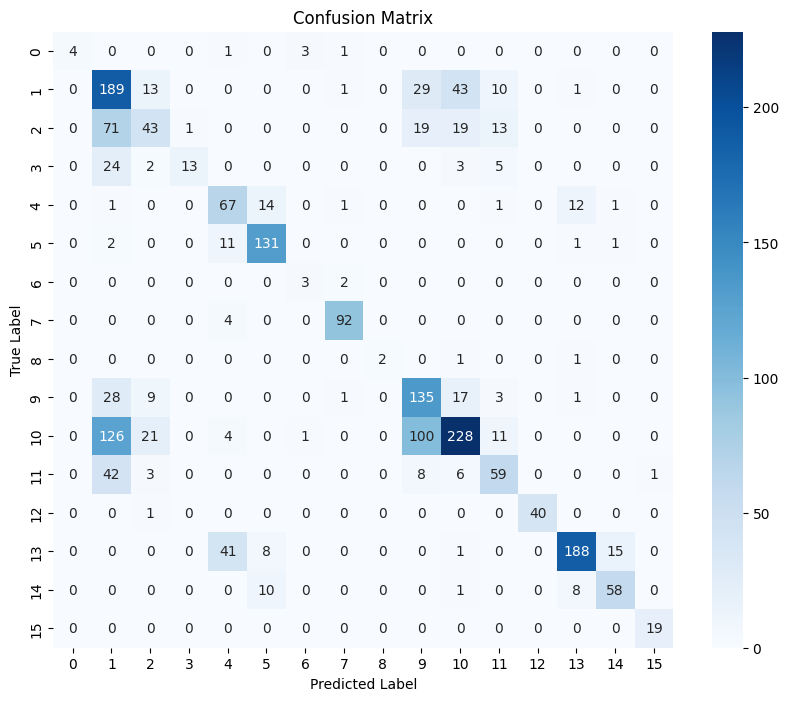

In [1]:
# =========================================================================
#               SIH Proof-of-Concept: Indian Pines Classifier (Python)
# =========================================================================
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

print("TensorFlow Version:", tf.__version__)

# --- Step 1: Load Data ---
print("\n--- Loading Data ---")
data_cube_mat = scipy.io.loadmat('Indian_pines_corrected.mat')
ground_truth_mat = scipy.io.loadmat('Indian_pines_gt.mat')

data_cube = data_cube_mat['indian_pines_corrected']
ground_truth = ground_truth_mat['indian_pines_gt']

print(f"Data Cube Shape: {data_cube.shape}")
print(f"Ground Truth Shape: {ground_truth.shape}")

# --- Step 2: Preprocess with PCA ---
print("\n--- Performing PCA ---")
# Reshape the 3D cube into a 2D matrix (pixels x bands)
height, width, bands = data_cube.shape
data_reshaped = data_cube.reshape((height * width, bands))

# Apply PCA
num_components = 3
pca = PCA(n_components=num_components)
pca_data = pca.fit_transform(data_reshaped)

# Reshape back to a 3D image
pca_data_reshaped = pca_data.reshape((height, width, num_components))
print(f"PCA completed. New data shape: {pca_data_reshaped.shape}")

# --- Step 3: Create Image Patches ---
print("\n--- Creating Image Patches ---")
patch_size = 9
pad_size = patch_size // 2

# Pad the PCA data to handle edges
padded_data = np.pad(pca_data_reshaped, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='edge')

patches = []
labels = []

# Find locations of labeled pixels
labeled_pixels = np.argwhere(ground_truth > 0)

for r, c in labeled_pixels:
    label = ground_truth[r, c]

    # Extract the 9x9 patch from the padded data
    # Note: we add pad_size to our coordinates because of the padding
    patch = padded_data[r : r + patch_size, c : c + patch_size, :]
    patches.append(patch)
    labels.append(label)

# Convert lists to NumPy arrays
X = np.array(patches)
y = np.array(labels)

# The ground truth labels start from 1, but our model needs them to start from 0.
# We also have a "background" class 0 which we should ignore.
# Let's subtract 1 to make them 0-indexed.
y = y - 1

print(f"Created {len(X)} image patches of size {patch_size}x{patch_size}")

# --- Step 4: Split Data and Prepare Labels ---
print("\n--- Splitting Data ---")
# Split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encode the labels for the Keras model
num_classes = len(np.unique(y))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

# --- Step 5: Define and Train the CNN Model ---
print("\n--- Building and Training CNN ---")
model = Sequential([
    Input(shape=(patch_size, patch_size, num_components)),
    Conv2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=num_classes, activation='softmax')
])

model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test_cat),
                    verbose=1)

# --- Step 6: Evaluate the Model ---
print("\n--- Evaluating Model ---")
loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

# Generate classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


--- Generating Full Classification Map ---
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


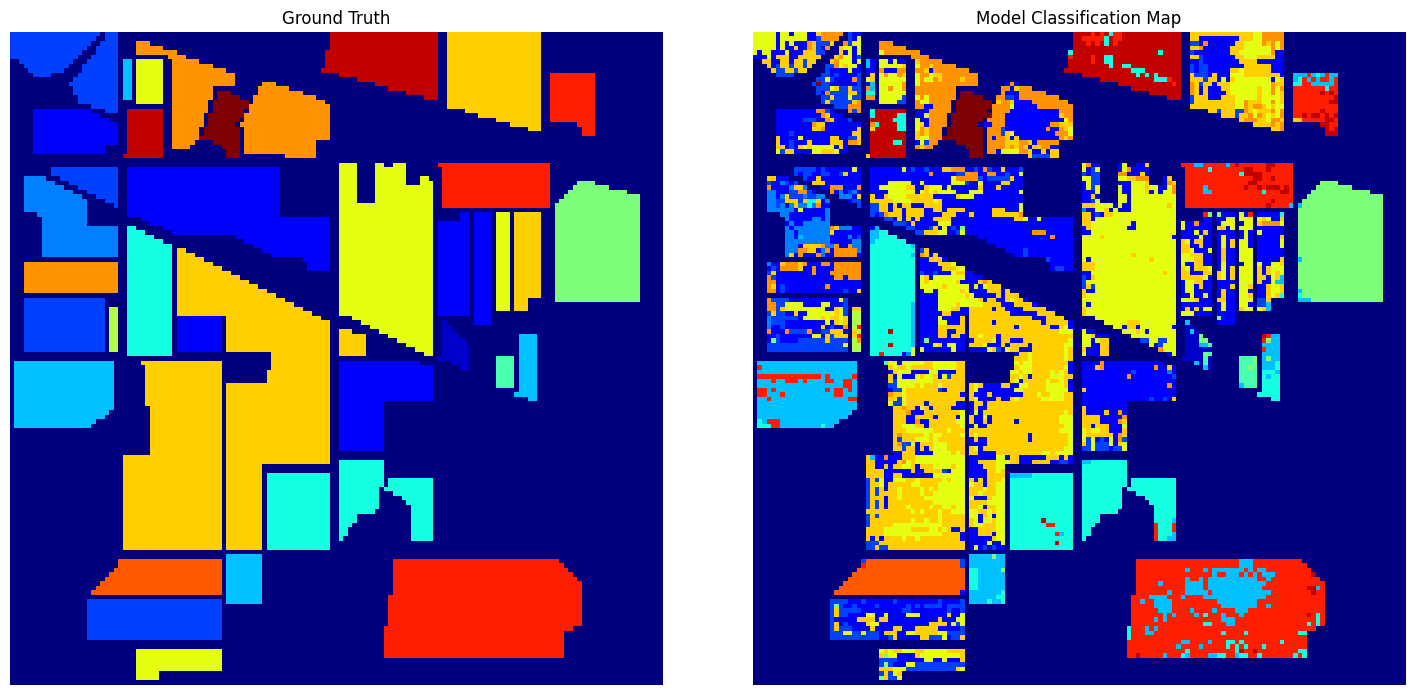


--- Script Finished ---


In [2]:
# --- Step 7: Visualize Predictions on the Full Field ---
print("\n--- Generating Full Classification Map ---")

# Use the trained model to predict the class for ALL patches we created
all_predictions = model.predict(X)
predicted_labels_all = np.argmax(all_predictions, axis=1)

# Create a blank map to store our predictions
prediction_map = np.zeros_like(ground_truth, dtype=np.int32)

# Place each prediction back into its correct (r, c) location on the map
for i, (r, c) in enumerate(labeled_pixels):
    # Add 1 back to the label to match the original ground truth numbering (1-16)
    prediction_map[r, c] = predicted_labels_all[i] + 1

# Display the maps side-by-side
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(ground_truth, cmap='jet')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(prediction_map, cmap='jet')
plt.title('Model Classification Map')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Script Finished ---")